In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/shua784/anaconda3/lib/python3.6/site-packages/flopy


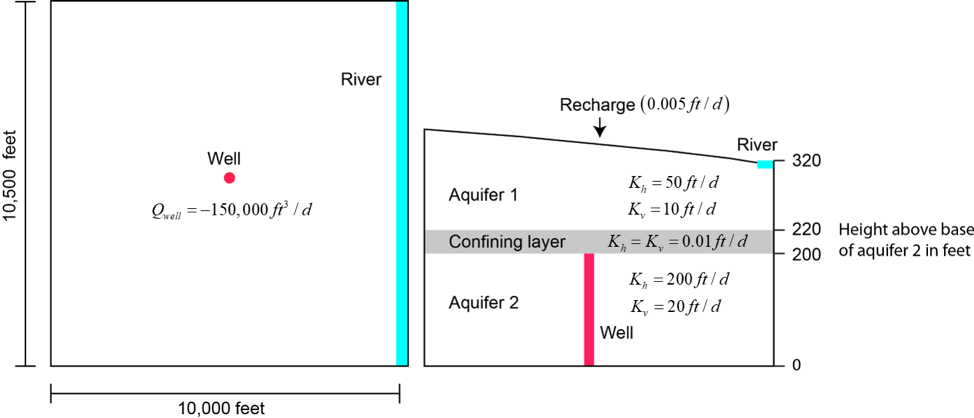

### Building and post-processing a MODFLOW 6 model

A MODFLOW 6 model will be developed of the domain shown above. This model simulation is based on example 1 in [Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086](https://doi.org/10.3133/ofr20161086).

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500. will `delr` and `delc`. The top of the model should be set to 400 and the bottom of the three layers should be set to 220, 200, and 0. The model has one steady-state stress period. 

Create a simulation object, a time discretization object, and a iterative model solution object using `flopy.mf6.MFSimulation()`, `flopy.mf6.ModflowTdis()`, and `flopy.mf6.ModflowIms()`, respectively. Use default values for all iterative model solution variables.

Before creating the simulation object you should define the simulation workspace (`sim_ws`) where the model files are, the simulation name (`name`), and the name and path of the model executable (`exe_name`).  The `sim_ws` should be set to `'data/ex01b'`, `name` should be set to `ex01b`, and `exe_name` should be set to `bin/mf6`.

In [2]:
ws = 'data/ex02b'
name = 'ex02b'
exe_name = os.path.abspath('../bin/mf6')

In [3]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name=exe_name, sim_ws=ws)

# create tdis package
tdis = flopy.mf6.ModflowTdis(sim)

# create iterative model solution
ims = flopy.mf6.ModflowIms(sim)

Create the gwf model object using `flopy.mf6.ModflowGwf()`. 

In [4]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

Create the discretization package using `flopy.mf6.ModflowGwfdis()`.

In [5]:
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220, 200, 0]

In [6]:
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

`flopy.plot.PlotMapView()` and `flopy.plot.PlotCrossSection()` can be used to confirm that the discretization is correctly defined.

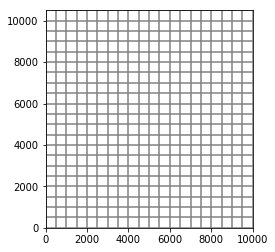

In [7]:
mm = flopy.plot.PlotMapView(model=gwf)
mm.plot_grid()

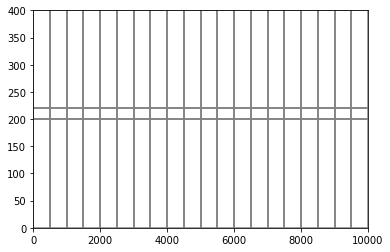

In [8]:
xs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 10})
xs.plot_grid()

#### Create the initial conditions (IC) package

Create the discretization package using `flopy.mf6.ModflowGwfic()` and set the initial head (`strt`) to 320. Default values can be used for the rest of the initial conditions package input.

In [9]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=320.)

#### Create the node property flow (NPF) package

The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so `icelltype` should be `[1, 0, 0]`. The variable `save_specific_discharge` should be set to `True` so that specific discharge data are saved to the cell-by-cell file and can be used to plot discharge.

In [10]:
kh = [50, 0.01, 200]
kv = [10, 0.01, 20]
icelltype = [1, 0, 0]

In [11]:
npf = flopy.mf6.ModflowGwfnpf(gwf, 
                              save_specific_discharge=True,
                              icelltype=icelltype,
                              k=kh,
                              k33=kv)

#### Create the recharge package

The recharge rate is defined in the image above. Use the `flopy.mf6.ModflowGwfrcha()` method to specify recharge data using arrays.

In [12]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005)

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above.

In [13]:
wel_spd = {0: [[(2, 10, 9), -150000]]}
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True,
                              stress_period_data=wel_spd)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.

In [14]:
riv_spd = {0: [[(0, i, 19), 320, 1e5, 318] for i in range(nrow)]}
riv_spd

{0: [[(0, 0, 19), 320, 100000.0, 318],
  [(0, 1, 19), 320, 100000.0, 318],
  [(0, 2, 19), 320, 100000.0, 318],
  [(0, 3, 19), 320, 100000.0, 318],
  [(0, 4, 19), 320, 100000.0, 318],
  [(0, 5, 19), 320, 100000.0, 318],
  [(0, 6, 19), 320, 100000.0, 318],
  [(0, 7, 19), 320, 100000.0, 318],
  [(0, 8, 19), 320, 100000.0, 318],
  [(0, 9, 19), 320, 100000.0, 318],
  [(0, 10, 19), 320, 100000.0, 318],
  [(0, 11, 19), 320, 100000.0, 318],
  [(0, 12, 19), 320, 100000.0, 318],
  [(0, 13, 19), 320, 100000.0, 318],
  [(0, 14, 19), 320, 100000.0, 318],
  [(0, 15, 19), 320, 100000.0, 318],
  [(0, 16, 19), 320, 100000.0, 318],
  [(0, 17, 19), 320, 100000.0, 318],
  [(0, 18, 19), 320, 100000.0, 318],
  [(0, 19, 19), 320, 100000.0, 318],
  [(0, 20, 19), 320, 100000.0, 318]]}

In [15]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

#### Build output control

Define the output control for the model using the `flopy.mf6.ModflowGwfoc` method to `[('HEAD', 'ALL'), ('BUDGET', 'ALL')]` to save the head and flow for the model. Because we haven't set `SAVE_FLOWS` to `True` in all of the  packages we can set `.name_file.save_flows` to `True` for the groundwater flow model (`gwf`) to save flows for all packages that can save flows. Also the head (`head_filerecord`) and cell-by-cell flow (`budget_filerecord`) files should be set to `name+'.hds'` and `name+'.cbc'`, respectively.

In [16]:
hname = '{}.hds'.format(name)
cname = '{}.cbc'.format(name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname,
                            head_filerecord=hname,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [17]:
gwf.name_file.save_flows = True

#### Write the model files and run the model

In [18]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model ex02b...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/shua784/Dropbox/github/MM2019_FloPy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
S

(True, [])

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. MODFLOW 6 creates double precision binary files so `precision='double'` needs to be passed to the `flopy.utils.CellBudgetFile()` method. The `flopy.utils.HeadFile()` method autodetects the precision of the head file. The precision of the head file is a attribute on the head file object (`hobs.precision`) and could be passed as the `precision` parameter.

In [19]:
fpth = os.path.join(ws, hname)
hobj = flopy.utils.HeadFile(fpth)

In [20]:
hds = hobj.get_data()

In [21]:
fpth = os.path.join(ws, cname)
cobj = flopy.utils.CellBudgetFile(fpth, precision=hobj.precision)

The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [22]:
cobj.list_unique_records()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
RIV                  6
RCH                  6


Retrieve the `'DATA-SPDIS'` data type from the cell-by-cell file.

In [23]:
spd = cobj.get_data(text='DATA-SPDIS')[0]

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

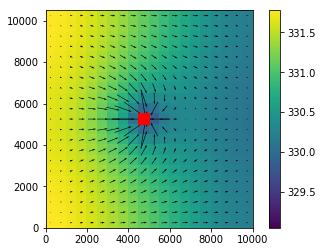

In [26]:
mm = flopy.plot.PlotMapView(model=gwf, layer=2)
c = mm.plot_array(hds)
mm.plot_specific_discharge(spd)
mm.plot_bc('RIV')
mm.plot_bc('WEL')
plt.colorbar(c)